Check the running torch version

In [1]:
import torch
torch.__version__

'1.2.0'

In [2]:
import sys

assert sys.version_info >= (3, 6) # Python ≥3.6 required

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Build a lines segmentation model based on unet architecture 

Here is [the paper](https://arxiv.org/pdf/1505.04597.pdf).

Checkout this [cheat sheet](https://pytorch.org/tutorials/beginner/ptcheat.html?highlight=loss) as a quick referesher.

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())  # Source: https://github.com/fastai/fastai/blob/master/fastai/core.py#L236

from tqdm import tqdm

from PIL import Image

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torchsummary import summary

In [5]:
from src.datasets import Dataset
from src.networks import UNetMini
from src.utils import img_to_array, array_to_img
from src.utils import to_categorical

In [6]:
lines_detector_path = Dataset.processed_data_path()/"lines-segmentation"

lines_detector_train_images_path = lines_detector_path/"train"/"images"
lines_detector_train_masks_path = lines_detector_path/"train"/"masks"

lines_detector_valid_images_path = lines_detector_path/"valid"/"images"
lines_detector_valid_masks_path = lines_detector_path/"valid"/"masks"

lines_detector_test_images_path = lines_detector_path/"test"/"images"
lines_detector_test_masks_path = lines_detector_path/"test"/"masks"

Hyperparameters

In [7]:
batch_size = 4
epochs = 4
learning_rate = 0.001

number_of_classes = 2

In [8]:
model_save_path = Path("../weights/lines_segmentation.ckpt")

## Load dataset

In [9]:
def load_images_and_masks_in_path(images_path: Path, masks_path: Path):
    x = []
    y = []

    sorted_image_names = sorted(images_path.glob("*.png"))
    sorted_mask_names = sorted(masks_path.glob("*.png"))
    for image_file_name, mask_file_name in tqdm(zip(sorted_image_names, sorted_mask_names)):
        image = img_to_array(Image.open(image_file_name))
        mask = img_to_array(Image.open(mask_file_name))

        x.append(image)
        y.append(mask)
        
    return np.array(x), np.array(y)

train_images, train_masks = load_images_and_masks_in_path(lines_detector_train_images_path, lines_detector_train_masks_path)
valid_images, valid_masks = load_images_and_masks_in_path(lines_detector_valid_images_path, lines_detector_valid_masks_path)
test_images, test_masks = load_images_and_masks_in_path(lines_detector_test_images_path, lines_detector_test_masks_path)

986it [00:01, 821.26it/s]
246it [00:00, 851.38it/s]
307it [00:00, 884.15it/s]


In [10]:
def get_transformations(train=False):
    transformations = []
    
    # Converts the image, a PIL image, into a PyTorch Tensor
    # It swap color axis because
    # numpy image: H x W x C
    # torch image: C X H X W
    transformations.append(transforms.ToTensor())
    
    # Make sure we apply the same transformations to the input image and mask images
    if train:
        # during training, do some more transformations
#         transformations.append(transforms.RandomHorizontalFlip())
#         transformations.append(transforms.RandomPerspective())
#         transformations.append(transforms.RandomRotation(degrees=(-40, 40)))
        pass
    
    return transforms.Compose(transformations)

In [11]:
class FormsDataset(Dataset):

    def __init__(self, images, masks, num_classes: int, transforms=None):
        self.images = images
        self.masks = masks
        self.num_classes = num_classes
        self.transforms = transforms

    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.astype(np.float32)
        image = np.expand_dims(image, -1)
        image = image / 255

#         seed = random.randint(0, 2**31 - 1)
#         random.seed(seed) # apply this seed to img tranfsorms
#         torch.manual_seed(seed)
        if self.transforms:
            image = self.transforms(image)
            
        mask = self.masks[idx]
        mask = mask.astype(np.float32)
        mask = mask / 255
        mask[mask > .7] = 1
        mask[mask <= .7] = 0
#         mask = mask.astype(np.uint8)
#         mask = to_categorical(mask, self.num_classes).astype(np.int)

#         random.seed(seed) # apply this seed to target tranfsorms
#         torch.manual_seed(seed)
        if self.transforms:
            mask = self.transforms(mask)

        return image, mask

    def __len__(self):
        return len(self.images)


train_dataset = FormsDataset(train_images, train_masks, number_of_classes, get_transformations(True))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f'Train dataset has {len(train_data_loader)} batches of size {batch_size}')

valid_dataset = FormsDataset(valid_images, valid_masks, number_of_classes, get_transformations(False))
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
print(f'Valid dataset has {len(valid_data_loader)} batches of size {batch_size}')

test_dataset = FormsDataset(test_images, test_masks, number_of_classes, get_transformations(False))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(f'Valid dataset has {len(test_data_loader)} batches of size {batch_size}')

Train dataset has 247 batches of size 4
Valid dataset has 62 batches of size 4
Valid dataset has 77 batches of size 4


Confirm that the dataset and loaders were initialized correctly

In [12]:
image, mask = train_dataset[0]
image.shape, mask.shape

(torch.Size([1, 256, 256]), torch.Size([1, 256, 256]))

In [13]:
for image, mask in train_data_loader:
    print(f"{image.shape}, {mask.shape}")
    print(f"{image.max()}, {mask.max()}")
    break

torch.Size([4, 1, 256, 256]), torch.Size([4, 1, 256, 256])
1.0, 1.0


## Build the model

In [14]:
model = UNetMini(number_of_classes).to(device)

summary(model, input_size=(1, 256, 256))  # (channels, H, W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
              ReLU-2         [-1, 32, 256, 256]               0
         Dropout2d-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
              ReLU-5         [-1, 32, 256, 256]               0
         MaxPool2d-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          18,496
              ReLU-8         [-1, 64, 128, 128]               0
         Dropout2d-9         [-1, 64, 128, 128]               0
           Conv2d-10         [-1, 64, 128, 128]          36,928
             ReLU-11         [-1, 64, 128, 128]               0
        MaxPool2d-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]          73,856
             ReLU-14          [-1, 128,

## Train the model

Define loss and optimizer

In [15]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Start training

In [16]:
# Train the model
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

for epoch in range(epochs):
    for i, (images, masks) in enumerate(train_data_loader, 1):
        images = images.to(device)
        masks = masks.type(torch.LongTensor)
        masks = masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3])
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        softmax = F.log_softmax(outputs, dim=1)
        loss = criterion(softmax, masks)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i) % 100 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{total_steps}], Loss: {loss.item():4f}")

4 epochs, 247 total_steps per epoch
Epoch [1/4], Step [100/247], Loss: 0.437021
Epoch [1/4], Step [200/247], Loss: 0.294868
Epoch [2/4], Step [100/247], Loss: 0.305917
Epoch [2/4], Step [200/247], Loss: 0.179446
Epoch [3/4], Step [100/247], Loss: 0.176930
Epoch [3/4], Step [200/247], Loss: 0.224016
Epoch [4/4], Step [100/247], Loss: 0.219176
Epoch [4/4], Step [200/247], Loss: 0.201426


# Save the model

In [17]:
torch.save(model.state_dict(), model_save_path)

## Restore the model

In [18]:
model = UNetMini(number_of_classes).to(device)
model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))
model.eval()

summary(model, input_size=(1, 256, 256))  # (channels, H, W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
              ReLU-2         [-1, 32, 256, 256]               0
         Dropout2d-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
              ReLU-5         [-1, 32, 256, 256]               0
         MaxPool2d-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          18,496
              ReLU-8         [-1, 64, 128, 128]               0
         Dropout2d-9         [-1, 64, 128, 128]               0
           Conv2d-10         [-1, 64, 128, 128]          36,928
             ReLU-11         [-1, 64, 128, 128]               0
        MaxPool2d-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]          73,856
             ReLU-14          [-1, 128,

## Test the model

In [19]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, masks in test_data_loader:
        images = images.to(device)
        masks = masks.type(torch.LongTensor)
        masks = masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3])
        masks = masks.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == masks).sum().item()
        
        mul = 1
        for d in masks.shape:
            mul *= d
        total += mul

    print(f"{correct} / {total}")
    print(f"Test Accuracy of the model on the {len(test_data_loader) * batch_size} test images: {100 * correct / total:.4f} %")

18166068 / 20119552
Test Accuracy of the model on the 308 test images: 90.2906 %


In [20]:
index = 0

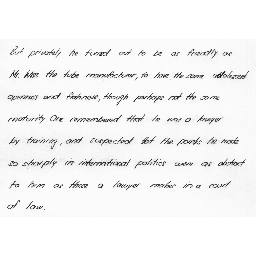

In [21]:
image = images[index].cpu().numpy()
image = np.transpose(image, (1, 2, 0))
image = np.squeeze(image) * 255
image = image.astype(np.uint8)

array_to_img(image)

In [22]:
softmax = F.softmax(outputs, dim=1).cpu().numpy()
softmax.shape

(3, 2, 256, 256)

In [23]:
outputs.max().item(), softmax.max().item()

(11.91637134552002, 1.0)

In [24]:
image_array = np.transpose(softmax[index], (1, 2, 0))
image_array.dtype, image_array.shape

(dtype('float32'), (256, 256, 2))

In [25]:
image_array = np.argmax(image_array, axis=2) * 255
# image_array = np.expand_dims(image_array, axis=-1)
image_array = image_array.astype(np.uint8)
image_array.dtype, image_array.shape, image_array.min(), image_array.mean(), image_array.max()

(dtype('uint8'), (256, 256), 0, 85.45005798339844, 255)

In [26]:
type(image_array)

numpy.ndarray

In [27]:
# for row in image_array:
#     if np.max(row) > 0:
#         print(row)
#     else:
#         print(">> EMPTY ROW <<")

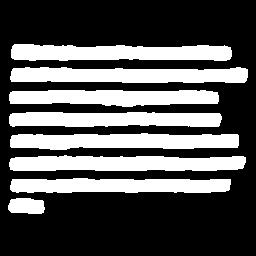

In [28]:
array_to_img(image_array)